# Notebook 2: Featurizing a dataset, and fitting a model, and viewing bond projections

This notebook, which builds upon notebook 1, shows:

- How to apply a fingerprinter to a dataset using a FingerprintFeaturizer.
- How to use those results as features for a model, including with standard scikit-learn models and with minervachjems's Hierarchical Residual Regression.
- Finally, we see how to visualize predictions from the model.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# Cheminformatics
from rdkit import Chem
from minervachem import fingerprinters as mfp

%load_ext autoreload
%autoreload 2

## 1: Preprocessing the data

We'll be working with the QM9 dataset:

Ramakrishnan, R., Dral, P., Rupp, M. et al. Quantum chemistry structures and properties of 134 kilo molecules. Sci Data 1, 140022 (2014). https://doi.org/10.1038/sdata.2014.22

This dataset is publically available, and we provide a python script to preprocess it into a CSV file that is convenient to work with. 

The script is `/demos/process_qm9.py`, and to run it you will need to download a few things from the QM9 dataset, and place them in a new folder `/demos/qm9_data_files/`. The items needed are:


1) `qm9_data_files/dsgdb9nsd.xyz.tar.bz2` - The main file, a tarball which contains inside it the properties for each molecule.
2) `qm9_data_files/uncharacterized.txt` - A list of molecules which failed a consistency check in the data generation process. These are usually excluded from machine learning analyses.
3) `qm9_data_files/atomref.txt` - Reference atom values for different types of energy calculations.

https://doi.org/10.6084/m9.figshare.978904

Run the script using:

    python preprocess_qm9.py
    
    
The script takes approximately 1 minute to run. When complete, you should now have a file called `/demos/qm9_processed.csv`.


In [2]:
df = pd.read_csv('./qm9_processed.csv')

In [3]:
print("Data frame shape:",df.shape)
print("Data frame columns:",df.columns)
print("Example item:")
print(df.iloc[0])

Data frame shape: (130831, 19)
Data frame columns: Index(['i', 'smiles', 'A', 'B', 'C', 'mu', 'alpha', 'e_homo', 'e_lumo',
       'e_gap', 'E_R^2', 'zpve', 'U_0', 'U', 'H', 'G', 'C_v', 'E_self_sum',
       'E_at'],
      dtype='object')
Example item:
i                        1
smiles                   C
A                 157.7118
B                157.70997
C                157.70699
mu                     0.0
alpha                13.21
e_homo             -0.3877
e_lumo              0.1171
e_gap               0.5048
E_R^2              35.3641
zpve              0.044749
U_0          -25400.912075
U            -25399.112378
H               -40.475117
G               -40.498597
C_v                  6.469
E_self_sum   -25004.912181
E_at           -395.999894
Name: 0, dtype: object


Next, we convert the molecules from SMILES strings to rdkit molecules: 

In [4]:
%%time
df['mol'] = df['smiles'].map(lambda s: Chem.AddHs(Chem.MolFromSmiles(s)))

CPU times: user 7.89 s, sys: 408 ms, total: 8.3 s
Wall time: 8.33 s


This makes it easier to see that the first molecule is, in fact, methane:

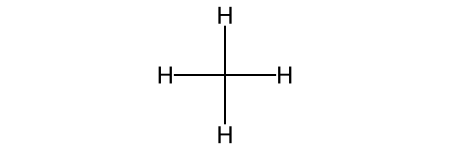

In [5]:
df['mol'].iloc[0]

## 2: Using the FingerprintFeaturizer to build a feature matrix
You may recall that the Fingerprinter objects in minerva returns dictionary information for each molecule.

To run a machine learning algorithm we usually require something like a *feature matrix*, where each row is a data item, and each column runs over the features for those data items. In order to construct this, minervachem provides a transformer called a FingerprintFeaturizer. The fingerprint featurizer is a wrapper around a fingerprinter which takes a list of molecules and returns a feature matrix, implicitly constructing the map between the fingerprint dictionary keys and the columns of the  matrix.

The featurizer also uses parallelization with the `joblib` library to use multiple cores on your computer for computing the fingerprints.


In [6]:
from minervachem.fingerprinters import GraphletFingerprinter
from minervachem.transformers import FingerprintFeaturizer


featurizer = FingerprintFeaturizer(
    fingerprinter=GraphletFingerprinter(max_len=5),
    verbose=0,         # Optional verbosity parameter
    # Parallel Arguments
    n_jobs=-3,         # For joblib, this means all n_cores-2. 
    chunk_size='auto', # Optional, how many molecules each core should do in a batch.
)

We use the method `fit_transform` to define the fingerprint fragments used in the training set, and the method `transform` to build the same set of fragments on the test set.

(This may take a few minutes at fingerprint size 5. At size 6 or higher, you may need some patience or larger computing resources.)

In [7]:
train, test = train_test_split(
    df, 
    train_size=0.8, 
    random_state=42,
)

X_train = featurizer.fit_transform(train['mol'])
X_test = featurizer.transform(test['mol'])

Constructing Fingerprints:   0%|          | 0/104664 [00:00<?, ?it/s]

Converting FPs to sparse:   0%|          | 0/104664 [00:00<?, ?it/s]

Constructing Fingerprints:   0%|          | 0/26167 [00:00<?, ?it/s]

Converting FPs to sparse:   0%|          | 0/26167 [00:00<?, ?it/s]

Converting FPs to sparse:   0%|          | 0/26167 [00:00<?, ?it/s]

The output features are a sparse matrix:

In [8]:
type(X_train), X_train.shape

(scipy.sparse._csr.csr_matrix, (104664, 5995))

The map between training bits and columns is provided by the `.bit_ids_` attribute, which is a `list`:

In [9]:
featurizer.bit_ids_[:5]

[(1, 9721667903896824216),
 (1, 9990529426805722067),
 (1, 10644171177213713952),
 (1, 11157825732388760594),
 (1, 12700027725287632904)]

The inverse map is provided by the `.bit_indices_`, a `dict`:

In [10]:
featurizer.bit_indices_[featurizer.bit_ids_[0]]

0

In practice, you probably won't need to look at the `.bit_map_` or `.bit_ids_` much, except when constructing `GraphletDAG`s. 

## 3: Fitting a Ridge Regression Model
Now that we have feature matrices, let us fit a linear regression with Ridge regularization:

(as a small aside, the `sparse_cg` solver becomes very useful as the fingerprint size is increased)

In [11]:
y_train, y_test = [sub_df['E_at'] for sub_df in [train, test]]

from sklearn.linear_model import Ridge
model = Ridge(fit_intercept=False, 
              alpha=1e-5, 
              solver='sparse_cg', 
              tol=1e-5)

In [12]:
%%time
model.fit(X_train, y_train)

CPU times: user 2.17 s, sys: 35.2 ms, total: 2.2 s
Wall time: 2.21 s


Ridge(alpha=1e-05, fit_intercept=False, solver='sparse_cg', tol=1e-05)

Minerva also has some plotting tools to help visualize the results of a model on train and test pairs:

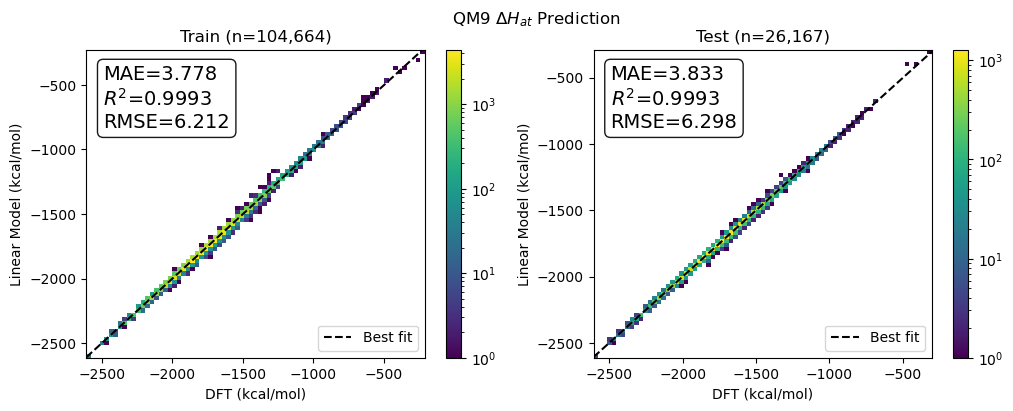

In [13]:
from minervachem.plotting import parity_plot_train_test
parity_plot_train_test([X_train, X_test], 
                       [y_train, y_test],
                       model, 
                       figsize=(12, 4),
                       xlab='DFT (kcal/mol)', 
                       ylab='Linear Model (kcal/mol)', 
                       title='QM9 $\Delta H_{at}$ Prediction', 
                       bins=75
                      );

# 4: Fitting a hierarchical model and visualizing the results

A hierarchical model will first use the smallest available features in order to fit the results, followed by larger features. The definition of "small" and "larger" is slightly different for different features, but for graphlet fingerprints you can think of it like this:

- First model: Use the atom counts, equivalently, the moelcular formula, to determine the result.
- Second model: Use the atoms and their bonds to each other to determine the result.
- Similarly for size 3 fragments, size 4, and so on

To make a hierarchical model, we have to construct a prototype model, which will be cloned and fit to each level of the hieararchical regression.

In [14]:
from minervachem.regressors import HierarchicalResidualModel

base_model = Ridge(fit_intercept=False, 
              alpha=1e-5,
              solver='sparse_cg')

hmodel = HierarchicalResidualModel(regressor=base_model,verbose=1)

/vast/home/mtynes/miniforge3/envs/minervachem/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


To fit the hierarchical model, we need to indicate to it which features belong to which level of the hierarchy. The FingerprintFeaturizer has an attribute for this called `bit_sizes_`.

In [15]:
hmodel.fit(X_train,y_train,levels=featurizer.bit_sizes_)

Regressor levels::   0%|          | 0/5 [00:00<?, ?it/s]

For most settings, the hierarchical model manages improvements over the non-hierarchical model:

In [16]:
X_train.shape

(104664, 5995)

In [17]:
hmodel.coef_.shape

(5995,)

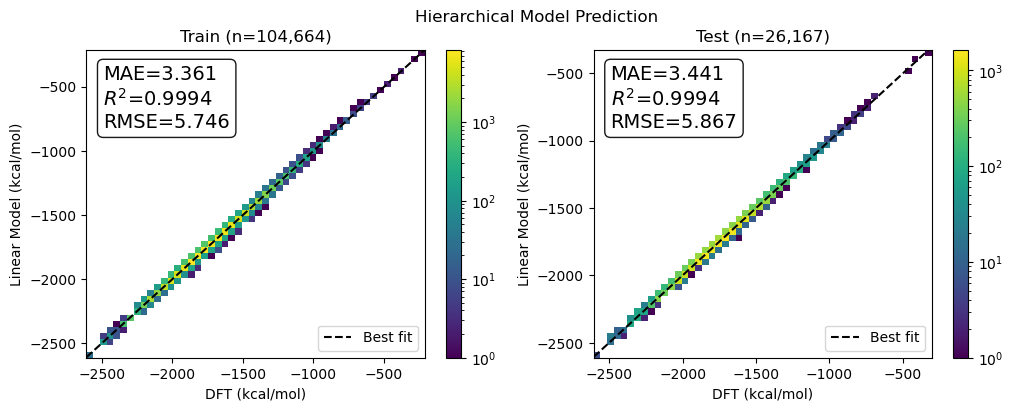

In [18]:
parity_plot_train_test([X_train, X_test], 
                       [y_train, y_test],
                       hmodel, 
                       figsize=(12, 4),
                       xlab='DFT (kcal/mol)', 
                       ylab='Linear Model (kcal/mol)', 
                       title='Hierarchical Model Prediction');
plt.savefig('hmodel_perf.png')

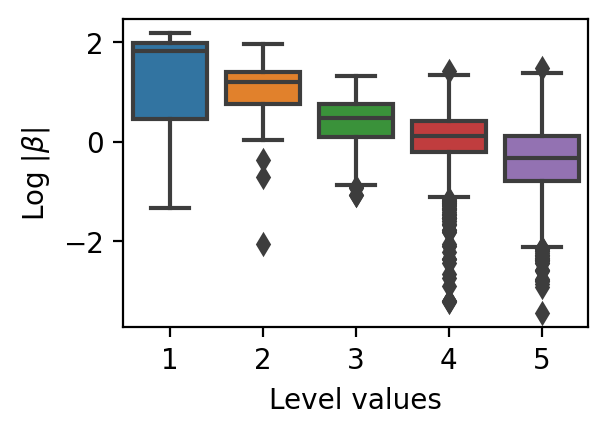

In [19]:
fig,ax = plt.subplots(figsize=(3,2),dpi=200)
hmodel.plot_coefs()
plt.ylabel("Log |$\\beta$|")
plt.xlabel("Level values")
plt.show()

## 5: Visualizing a bond-level projection of energy


In [20]:
from minervachem.graphlet_dags import GraphletDAG

In [21]:
smiles_strings = ['CC','C=C','C#C']

mols = [Chem.AddHs(Chem.MolFromSmiles(s)) for s in smiles_strings]

dags=[]
for mol in mols:
    dag =  GraphletDAG(mol,
                       fingerprinter=featurizer.fingerprinter, # the fingerprinter to use
                       bit_ids=featurizer.bit_ids_, # The bit id for each entry in the attributes, `attrib`.
                       coef=hmodel.coef_ # The attribute values (model coefficients) as an array.
                     )
    dags.append(dag)

Currently, the main thing to do with a substructure graph is to visualize interpretations of the prediction!

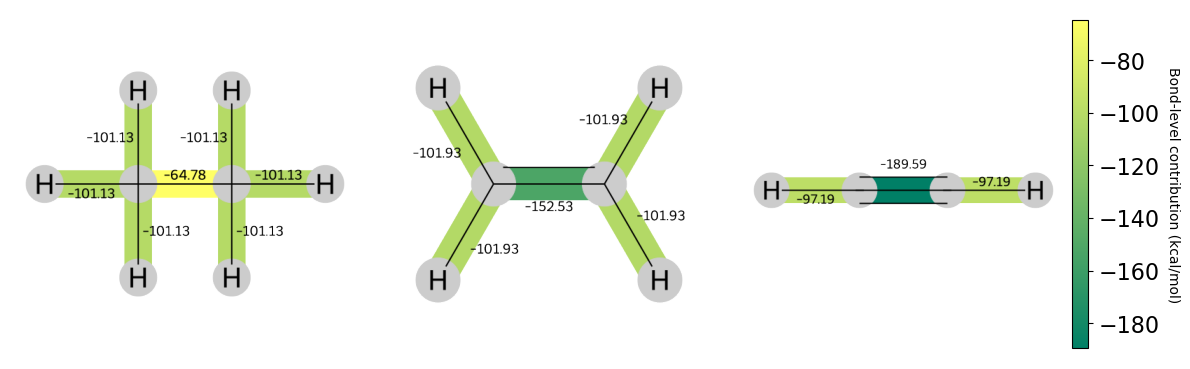

In [25]:
from minervachem.graphlet_dags import draw_projected_coefs
draw_projected_coefs(dags,
                     level=2,
                     figsize=(12,12),
                     ncol=len(dags),
                     cbar_label='Bond-level contribution (kcal/mol)'
                    )
plt.tight_layout()
plt.savefig('hmodel_interp.png', bbox_inches='tight')

The projections match with the predictions of the model:

In [23]:
featurizer.n_jobs = 1 # paralellism here is unwarranted
featurizer.verbose = False # as is verbosity
hmodel.predict(featurizer.transform(mols))

Constructing Fingerprints:   0%|          | 0/3 [00:00<?, ?it/s]

Converting FPs to sparse:   0%|          | 0/3 [00:00<?, ?it/s]

Converting FPs to sparse:   0%|          | 0/3 [00:00<?, ?it/s]

array([-671.52884458, -560.25571296, -383.97465272])

In [24]:
[dag.project_to_layer(1).sum() for dag in dags]

[-671.5288445769891, -560.2557129639357, -383.97465272113635]